In [268]:
import pandas as pd
import numpy as np

news = pd.read_csv('news_articles.csv')
news = news[news['language'] == 'english']

news.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


Remove unimportant columns and add a length column. Typically articles below a certain length threshold are very
unlikely to actually be articles. Let's remove observations with text below a certain length.

In [269]:
# remove all columns except publication data, title, text, type, and label
news = news[['published', 'title', 'text', 'type', 'label']].dropna().reset_index(drop=True)

# add a length feature
news['length']  = news['text'].str.len()

# remove observation with text below and above a certain length
news = news.loc[news['length'] >= 500]
news = news.loc[news['length'] <= 15000]

news.head()

,published,title,text,type,label,length
1,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,bias,Real,1724
2,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,bias,Real,1326
4,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,bias,Real,2052
5,2016-11-02T16:31:28.550+02:00,hillary goes absolutely berserk on protester a...,print hillary goes absolutely berserk she expl...,bias,Real,1165
6,2016-11-04T19:40:00.000+02:00,breaking nypd ready to make arrests in weiner ...,breaking nypd ready to make arrests in weiner ...,bias,Real,5653


Create histogram to examine number of articles with 'Real' vs 'Fake' labels.

In [270]:
import plotly.express as px

fig = px.histogram(news, x="label")
fig.show()

Examine distribution or article types.

In [271]:
fig = px.histogram(news, x="type")
fig.show()

Evaluate distribution of article lengths.

In [272]:
fig = px.histogram(news, x="length")
fig.show()

In [273]:
fig = px.histogram(news, x="length", color="label")
fig.show()

In [274]:
# Load the regular expression library
import re
# Remove punctuation
news['title_processed'] = \
news['title'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert text to lowercase
news['title_processed'] = \
news['title_processed'].map(lambda x: x.lower())
# Print out the first rows of news
news['title_processed'].head()

1    re why did attorney general loretta lynch plea...
2    breaking weiner cooperating with fbi on hillar...
4    fantastic trumps  point plan to reform healthc...
5    hillary goes absolutely berserk on protester a...
6    breaking nypd ready to make arrests in weiner ...
Name: title_processed, dtype: object

In [275]:
# # Import the wordcloud library
# from wordcloud import WordCloud
# # Join the different processed titles together.
# long_string = ','.join(list(news['title_processed'].values))
# # Create a WordCloud object
# wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# # Generate a word cloud
# wordcloud.generate(long_string)
# # Visualize the word cloud
# wordcloud.to_image()

In [276]:
# #Prepare for LDA analysis
# import gensim
# from gensim.utils import simple_preprocess
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# def sent_to_words(sentences):
#     for sentence in sentences:
#         # deacc=True removes punctuations
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stop_words] for doc in texts]
# data = news.title_processed.values.tolist()
# data_words = list(sent_to_words(data))
# # remove stop words
# data_words = remove_stopwords(data_words)
# print(data_words[:1][0][:30])

In [277]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(data_words)
# # Create Corpus
# texts = data_words
# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]
# # View
# print(corpus[:1][0][:30])

In [278]:
# #LDA
# from pprint import pprint
# # number of topics
# num_topics = 4
# # Build LDA model
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=num_topics)

In [279]:
# # Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [280]:
# # Visualize the topics
# # 1. Wordcloud of Top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import STOPWORDS
# import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=10,
#                   colormap='tab10',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)

# topics = lda_model.show_topics(formatted=False)

# fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

In [281]:
# perform stratified sampling to get a balanced, sample dataset
sample_news = news.groupby('label', group_keys=False).apply(lambda x: x.sample(100, random_state=1))
news = news.drop(sample_news.index)

# shuffle the observations so real and fake labels are not grouped together
from sklearn.utils import shuffle
sample_news = shuffle(sample_news, random_state=1)

sample_news.head()

,published,title,text,type,label,length,title_processed
1216,2016-10-26T21:21:57.313+03:00,leaked hillary would completely ban the most p...,surgeons admit that mammography is outdated an...,junksci,Fake,3884,leaked hillary would completely ban the most p...
1762,http://theeconomiccollapseblog.com/wp-content/...,bs,ezekiel emanuel laughed on wednesday as the ho...,bs,Fake,2689,bs
52,2016-11-17T00:41:00.000+02:00,cbs minutes withheld trumps appeal to stop at...,november by wire leave a comment \r\nwilliam...,conspiracy,Fake,2254,cbs minutes withheld trumps appeal to stop at...
1701,2016-11-10T23:00:59.603+02:00,what the election has exposed,reply \r\naccording to numerous reports and s...,hate,Real,6078,what the election has exposed
1350,2016-10-28T18:10:27.176+03:00,the banishment of trump has begun as the ameri...,by hrafnkell haraldsson on mon oct st at pm ...,bias,Real,3343,the banishment of trump has begun as the ameri...


At the moment, the text is unbearable to read. Let's add punctuation using Hugging Face's bert-restore-punctuation.

In [282]:
from deepmultilingualpunctuation import PunctuationModel

model = PunctuationModel()

def apply_function_to_partitions(input_string):
    # Split the input string into 10 partitions
    n = len(input_string)
    partition_size = n // 10
    partitions = [input_string[i:i+partition_size] for i in range(0, n, partition_size)]

    # Apply the function to each partition
    partition_results = [model.restore_punctuation(str(partition)) for partition in partitions]
    
    # Remove unnecessary final period at end of each string
    partition_results = [partition[:-1] for partition in partition_results]

    # Concatenate the results and return the final string
    return ''.join(partition_results)


sample_news['cleaned'] = 0
sample_news['cleaned'] = sample_news['text'].map(lambda x: apply_function_to_partitions(x))
    
sample_news.head()

loading configuration file config.json from cache at C:\Users\nicol/.cache\huggingface\hub\models--oliverguhr--fullstop-punctuation-multilang-large\snapshots\9977cb96c2c89abe7fa7adcfebf6d79808544bd4\config.json
Model config XLMRobertaConfig {
  "_name_or_path": "oliverguhr/fullstop-punctuation-multilang-large",
  "architectures": [
    "XLMRobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "0",
    "1": ".",
    "2": ",",
    "3": "?",
    "4": "-",
    "5": ":"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    ",": 2,
    "-": 4,
    ".": 1,
    "0": 0,
    ":": 5,
    "?": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 2

,published,title,text,type,label,length,title_processed,cleaned
1216,2016-10-26T21:21:57.313+03:00,leaked hillary would completely ban the most p...,surgeons admit that mammography is outdated an...,junksci,Fake,3884,leaked hillary would completely ban the most p...,surgeons admit that mammography is outdated an...
1762,http://theeconomiccollapseblog.com/wp-content/...,bs,ezekiel emanuel laughed on wednesday as the ho...,bs,Fake,2689,bs,ezekiel emanuel laughed on wednesday as the ho...
52,2016-11-17T00:41:00.000+02:00,cbs minutes withheld trumps appeal to stop at...,november by wire leave a comment \r\nwilliam...,conspiracy,Fake,2254,cbs minutes withheld trumps appeal to stop at...,november by wire. leave a comment. william mcg...
1701,2016-11-10T23:00:59.603+02:00,what the election has exposed,reply \r\naccording to numerous reports and s...,hate,Real,6078,what the election has exposed,reply. according to numerous reports and stori...
1350,2016-10-28T18:10:27.176+03:00,the banishment of trump has begun as the ameri...,by hrafnkell haraldsson on mon oct st at pm ...,bias,Real,3343,the banishment of trump has begun as the ameri...,by hrafnkell haraldsson on mon oct st at pm. t...


In [283]:
def capitalize_sentences(s):
    # Split the string into sentences using period (.), exclamation mark (!), or question mark (?) as the delimiter
    sentences = re.split('(?<=[.!?]) +', s)
    
    # Capitalize the first letter of each sentence
    capitalized_sentences = [sentence.capitalize() for sentence in sentences]
    
    # Join the sentences back together
    result = ' '.join(capitalized_sentences)
    
    return result

sample_news['cleaned'] = sample_news['cleaned'].map(lambda x: capitalize_sentences(x))

sample_news.head()

,published,title,text,type,label,length,title_processed,cleaned
1216,2016-10-26T21:21:57.313+03:00,leaked hillary would completely ban the most p...,surgeons admit that mammography is outdated an...,junksci,Fake,3884,leaked hillary would completely ban the most p...,Surgeons admit that mammography is outdated an...
1762,http://theeconomiccollapseblog.com/wp-content/...,bs,ezekiel emanuel laughed on wednesday as the ho...,bs,Fake,2689,bs,Ezekiel emanuel laughed on wednesday as the ho...
52,2016-11-17T00:41:00.000+02:00,cbs minutes withheld trumps appeal to stop at...,november by wire leave a comment \r\nwilliam...,conspiracy,Fake,2254,cbs minutes withheld trumps appeal to stop at...,November by wire. Leave a comment. William mcg...
1701,2016-11-10T23:00:59.603+02:00,what the election has exposed,reply \r\naccording to numerous reports and s...,hate,Real,6078,what the election has exposed,Reply. According to numerous reports and stori...
1350,2016-10-28T18:10:27.176+03:00,the banishment of trump has begun as the ameri...,by hrafnkell haraldsson on mon oct st at pm ...,bias,Real,3343,the banishment of trump has begun as the ameri...,By hrafnkell haraldsson on mon oct st at pm. T...


In [284]:
# # Split dataframe into 20 equal parts
# split_df = np.array_split(sample_news, 20)

# # Loop over each part and write to a separate text file
# for i, part in enumerate(split_df):
    
#     text_list = list(part['cleaned'])
    
#     with open(f"panel_surveys/panel_{i}.txt", 'w') as f:
#         for line in text_list:
#             f.write(f"NEXT ARTICLE:\n\n{line}\n\n\n")
    
#     f.close()

# sample_news[['cleaned']].to_csv('for_chatGPT.csv', encoding='utf-8')

In [285]:
news['label'] = news['label'].replace(['Fake','Real'],[0,1])
sample_news['label'] = sample_news['label'].replace(['Fake','Real'],[0,1])

# perform sampling to get a test dataset, we want about 60% Fake and 40% Real because
# that was the ratio of the original dataset
# Randomly sample rows with label 0
sampled_zeros = news[news['label'] == 0].sample(n=120, random_state=1)
news = news.drop(sampled_zeros.index)
# Randomly sample rows with label 1
sampled_ones = news[news['label'] == 1].sample(n=80, random_state=1)
news = news.drop(sampled_ones.index)
# Concatenate the two samples together
news_test = pd.concat([sampled_zeros, sampled_ones])
news_test = shuffle(news_test, random_state=1)

news_y_test = news_test['label']
news_X_test = news_test['text']

# split into training and test set (scikitlearn)
from sklearn.model_selection import train_test_split

# # for full dataset
# news_X_train, news_X_test, news_y_train, news_y_test = train_test_split(news['text'], news['label'], stratify = news['label'], test_size=0.2)
# news_X_train, news_X_valid, news_y_train, news_y_valid = train_test_split(news_X_train, news_y_train, stratify = news_y_train, test_size=0.2)

# for sample dataset
news_X_train = sample_news['text']
news_y_train = sample_news['label']
news_X_valid = news_X_test
news_y_valid = news_y_test

# # for sample + chunk of full dataset for better overall accuracy
# chunk = news.groupby('label', group_keys=False).apply(lambda x: x.sample(250, random_state=1))
# chunk = shuffle(chunk, random_state=1)
# hybrid = pd.concat([sample_news, chunk])
# hybrid['label'] = hybrid['label'].replace(['Fake','Real'],[0,1])
# news_X_train, news_X_valid, news_y_train, news_y_valid = train_test_split(hybrid['text'], hybrid['label'], stratify = hybrid['label'], test_size=0.1)
# news_X_test, temp_X, news_y_test, temp_y = train_test_split(news['text'], news['label'], stratify = news['label'], test_size=0.5)


In [286]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

loading file vocab.json from cache at C:\Users\nicol/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\vocab.json
loading file merges.txt from cache at C:\Users\nicol/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at C:\Users\nicol/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_

In [287]:
max_length = 512

news_X_train = [str(i) for i in news_X_train.values]
news_X_valid = [str(i) for i in news_X_valid.values]

train_encodings = tokenizer(news_X_train, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(news_X_valid, truncation=True, padding=True, max_length=max_length)

In [288]:
import torch

class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = FakeNewsDataset(train_encodings, news_y_train.to_numpy())
valid_dataset = FakeNewsDataset(valid_encodings, news_y_valid.to_numpy())

In [289]:
# load the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

loading configuration file config.json from cache at C:\Users\nicol/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at C:\Users\nicol/.cache\huggingface\hub\models--roberta-base\snapshots\bc2764f8af2e92b6eb5679868df33e224075ca68\pytorch_model.bin
Some we

In [290]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [291]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=25,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=400,               # log & save weights each logging_steps
    save_steps=400,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

using `logging_steps` to initialize `eval_steps` to 400
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [292]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [293]:
import os

os.environ["WANDB_DISABLED"] = "true"

# train the model
trainer.train()

C:\Users\nicol\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

***** Running training *****
  Num examples = 180
  Num Epochs = 25
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 575
  Number of trainable parameters = 124647170


Step,Training Loss,Validation Loss,Accuracy
400,0.340200,0.916067,0.800000


***** Running Evaluation *****
  Num examples = 20
  Batch size = 20
Saving model checkpoint to ./results\checkpoint-400
Configuration saved in ./results\checkpoint-400\config.json
Model weights saved in ./results\checkpoint-400\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results\checkpoint-400 (score: 0.9160668253898621).


TrainOutput(global_step=575, training_loss=0.270691442074983, metrics={'train_runtime': 15959.1616, 'train_samples_per_second': 0.282, 'train_steps_per_second': 0.036, 'total_flos': 1183999749120000.0, 'train_loss': 0.270691442074983, 'epoch': 25.0})

In [294]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 20
  Batch size = 20


{'eval_loss': 0.9160668253898621,
 'eval_accuracy': 0.8,
 'eval_runtime': 25.3848,
 'eval_samples_per_second': 0.788,
 'eval_steps_per_second': 0.039,
 'epoch': 25.0}

In [295]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return probs.argmax().numpy()

In [296]:
pred_vector = news_X_test.map(lambda x: get_prediction(str(x)))

In [297]:
from sklearn.metrics import classification_report
print(classification_report(news_y_test, pred_vector))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       120
           1       0.70      0.85      0.77        80

    accuracy                           0.80       200
   macro avg       0.79      0.80      0.79       200
weighted avg       0.81      0.80      0.80       200



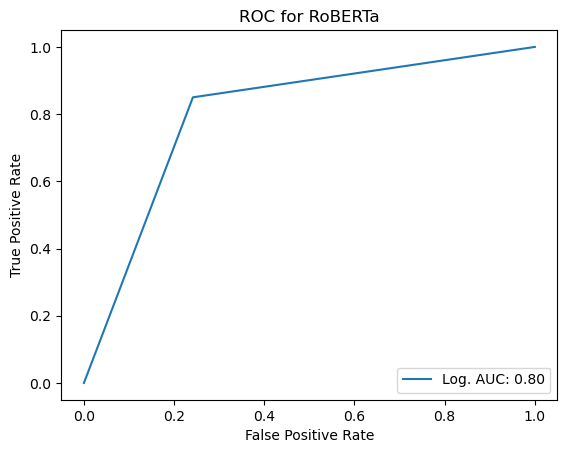

In [298]:
# make roc curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# metrics for logistic regression
fpr_logreg, tpr_logreg, _ = roc_curve(news_y_test, pred_vector)
auc_logreg = roc_auc_score(news_y_test, pred_vector)

# plot the info
plt.plot(fpr_logreg, tpr_logreg, label='Log. AUC: {0:0.2f}'.format(auc_logreg))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for RoBERTa')
plt.legend(loc='lower right')
plt.show()

Create a different tokenizer for our non-RoBERTa models.

In [317]:
import string
import nltk
from nltk.stem.lancaster import LancasterStemmer
from spacy.lang.en.stop_words import STOP_WORDS

stemmer = LancasterStemmer()

# Creating our tokenizer function
def text_process(mess):
    
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Tokenize
    3. convert them to lower case
    4. Remove all stopwords
    3. Perform stemming
    4. Returns a list of the cleaned text
    """

    stopwordList = spacy.lang.en.stop_words.STOP_WORDS

    # Check characters to see if they are in punctuation
    mess = [char for char in mess if char not in string.punctuation]
     # Join the characters again to form the string.
    mess = ''.join(mess)
    
    words = nltk.word_tokenize(mess)
    words = [t for t in words if t not in stopwordList]
    words = [stemmer.stem(w.lower()) for w in words]
    
    return words

In [318]:
from sklearn.base import TransformerMixin

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [325]:
#To create features from the texts
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
nltk.download('punkt')

pipeline = Pipeline([
    ('cleaner', predictors()),  # strings to token integer counts
    ('tfidf', TfidfVectorizer(tokenizer=text_process)),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [360]:
pipeline.fit(news_X_train, news_y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x000001BD35FB5370>),
                ('tfidf',
                 TfidfVectorizer(tokenizer=<function text_process at 0x000001BD2742BF70>)),
                ('classifier', LogisticRegression())])

In [361]:
predictions = pipeline.predict(news_X_test)

In [362]:
print(classification_report(news_y_test, pred_vector))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       120
           1       0.70      0.85      0.77        80

    accuracy                           0.80       200
   macro avg       0.79      0.80      0.79       200
weighted avg       0.81      0.80      0.80       200



In [351]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [45, 50, 55, 60, 65],
              "min_samples_leaf": [2, 3, 4, 5, 6, 7],
              "n_estimators": list(range(150, 199)),}

# Instantiate a Gradient Boosted Random Forest classifier: forest
forest = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: forest_cv
# I will use randomized search because grid search is taking too long
forest_cv = RandomizedSearchCV(forest, param_dist, cv=5, n_iter=50)

forest_pipe = Pipeline([('cleaner', predictors()),
                 ('tfidf', TfidfVectorizer(tokenizer = text_process)),
                 ('classifier', forest_cv)])

# Fit it to the data
forest_pipe.fit(news_X_train, news_y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(forest_pipe['classifier'].best_params_))
print("Best score is {}".format(forest_pipe['classifier'].best_score_))

Tuned Random Forest Parameters: {'n_estimators': 163, 'min_samples_leaf': 2, 'max_depth': 45}
Best score is 0.6555555555555556


In [352]:
forest_predictions = forest_pipe.predict(news_X_test)

print(classification_report(forest_predictions, news_y_test))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71       102
           1       0.71      0.58      0.64        98

    accuracy                           0.68       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200



In [353]:
from xgboost import XGBClassifier

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [50, 55, 60, 65, 70],
              "n_estimators": list(range(150, 199)),
              "learning_rate": [0.01, 0.05, 0.1, 0.25, 0.5]}

# Instantiate a Gradient Boosted Random Forest classifier: forest
GB = XGBClassifier()

# Instantiate the RandomizedSearchCV object: GB_cv
gb_cv = RandomizedSearchCV(GB, param_dist, cv=5, n_iter=50)

gb_pipe = Pipeline([('cleaner', predictors()),
                 ('tfidf', TfidfVectorizer(tokenizer = text_process)),
                 ('classifier', gb_cv)])

# Fit it to the data
gb_pipe.fit(news_X_train, news_y_train)

# Print the tuned parameters and score
print("Tuned GB Random Forest Parameters: {}".format(gb_pipe['classifier'].best_params_))
print("Best score is {}".format(gb_pipe['classifier'].best_score_))

Tuned GB Random Forest Parameters: {'n_estimators': 186, 'max_depth': 55, 'learning_rate': 0.01}
Best score is 0.711111111111111


In [354]:
gb_predictions = gb_pipe.predict(news_X_test)

print(classification_report(gb_predictions, news_y_test))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       120
           1       0.60      0.60      0.60        80

    accuracy                           0.68       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.68      0.68      0.68       200



In [357]:
from sklearn import svm

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"C": [0.5, 1, 2, 3, 5, 7, 11, 13, 19],
              "class_weight": ['balanced', None]}

# Instantiate a Gradient Boosted Random Forest classifier: forest
svm = svm.SVC(kernel = 'rbf')

# Instantiate the RandomizedSearchCV object: GB_cv
svm_cv = RandomizedSearchCV(svm, param_dist, cv=5, n_iter=15)

svm_pipe = Pipeline([('cleaner', predictors()),
                 ('tfidf', TfidfVectorizer(tokenizer = text_process)),
                 ('classifier', svm_cv)])

# Fit it to the data
svm_pipe.fit(news_X_train, news_y_train)

# Print the tuned parameters and score
print("Tuned GB Random Forest Parameters: {}".format(svm_pipe['classifier'].best_params_))
print("Best score is {}".format(svm_pipe['classifier'].best_score_))

Tuned GB Random Forest Parameters: {'class_weight': 'balanced', 'C': 7}
Best score is 0.5944444444444444


In [358]:
svm_predictions = svm_pipe.predict(news_X_test)

print(classification_report(svm_predictions, news_y_test))

              precision    recall  f1-score   support

           0       0.50      0.78      0.61        77
           1       0.79      0.51      0.62       123

    accuracy                           0.61       200
   macro avg       0.64      0.65      0.61       200
weighted avg       0.68      0.61      0.62       200

